In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import json
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
from keras import backend as K
# from tensorflow.keras.metrics import DiceCoefficient

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [ ]:
# Correct recall for tf
def recall_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(Y_true * Y_pred)
    possible_positives = tf.reduce_sum(Y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [ ]:
# Correct tf precision
def precision_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_true * Y_pred, 0, 1)))
    print(true_positives)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_pred, 0, 1)))
    print(predicted_positives)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [ ]:
# Correct tf dicecoefficient
def dice_coefficient_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    smooth = 1e-5

    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [ ]:
def dice_coefficient_loss(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)

    Y_pred = K.flatten(y_pred)

    smooth = 1e-5

    intersection = K.sum(Y_true * Y_pred)

    union = K.sum(Y_true) + K.sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [ ]:
def dice_coef_loss(y_true, y_pred):
    loss = - dice_coefficient_loss(y_true, y_pred)
    return loss

FUNCTION TO GENERATE HEATMAP

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create a model that outputs both the last conv layer's output and the model's prediction
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # Assuming the model outputs a single-channel segmentation map
        # We use the mean activation across the image to focus on how all pixels together influence the model's prediction
        class_channel = tf.reduce_mean(preds)

    # Compute gradients
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the channels of the last convolutional layer with the corresponding gradients
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output[0]), axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Sample usage:
# last_conv_layer_name = 'conv2d_17'  # Replace with your layer's name
# img_array = X_test[10:11]  # Example input

# # Generate heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)




*   Generating Heatmap of batch of Images
*   Plotting the heatmaps


*   Saving the Plot





In [ ]:
def generate_heatmaps(img_array, model, last_conv_layer_name):
    heatmaps = []
    for img in img_array:
        heatmap = make_gradcam_heatmap(img[np.newaxis, ...], model, last_conv_layer_name)
        heatmaps.append(heatmap)
    return heatmaps

In [ ]:
def display_images_with_heatmaps(img_array, mask_array, heatmaps, save_path, alpha=0.6):
    num_images = img_array.shape[0]
    plt.figure(figsize=(15, num_images * 5))

    for i in range(num_images):
        original_img = img_array[i]
        mask_img = mask_array[i]
        # Ensure original_img has three channels
        if original_img.ndim == 2 or original_img.shape[-1] == 1:  # Grayscale image
            original_img = np.stack((original_img.squeeze(),) * 3, axis=-1)

        # if mask_img.ndim == 2 or mask_img.shape[-1] == 1:  # Grayscale image
        #     mask_img = np.stack((mask_img.squeeze(),) * 3, axis=-1)

        heatmap = heatmaps[i]

        # Normalize and resize heatmap
        heatmap = np.uint8(255 * heatmap)
        heatmap = plt.get_cmap('jet')(heatmap)[:, :, :3]
        heatmap = np.uint8(255 * heatmap)
        heatmap = tf.image.resize(heatmap, (original_img.shape[0], original_img.shape[1]))
        heatmap = np.uint8(heatmap.numpy())

        # thresholded_heatmap = heatmap.copy()
        normalized_heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
        thresholded_heatmap = normalized_heatmap.copy()
        thresholded_heatmap[thresholded_heatmap < 0.5] = 0
        print(np.min(thresholded_heatmap), np.max(thresholded_heatmap))


        # Original Image
        ax = plt.subplot(num_images, 4, i * 4 + 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')


        # Mask Image
        ax = plt.subplot(num_images, 4, i * 4 + 2)
        plt.imshow(mask_img.squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')


        # Heatmap
        ax = plt.subplot(num_images, 4, i * 4 + 3)
        plt.imshow(heatmap)
        plt.title("Heatmap")
        plt.axis('off')

        #Superimposed
        ax = plt.subplot(num_images, 4, i * 4 + 4)
        plt.imshow(original_img, cmap='gray')  # Use bicubic interpolation for the original image
        plt.imshow(thresholded_heatmap, alpha=0.5)
        plt.title("Superimposed")
        plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Image saved to {save_path}")
    plt.show()

In [ ]:
X_test = np.load('/content/drive/MyDrive/Dataset/Breast_Dataset_Final/X_test.npy')
X_test = np.expand_dims(X_test, axis=-1)
print(X_test.shape)
Y_test = np.load('/content/drive/MyDrive/Dataset/Breast_Dataset_Final/Y_test.npy')
Y_test = np.expand_dims(Y_test, axis=-1)
print(Y_test.shape)

(77, 128, 128, 1)
(77, 128, 128, 1)


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/7thSem_Models/Breast/UNet/DiceLoss/unet_breast_model128.h5',custom_objects={'recall_tf': recall_tf, 'precision_tf': precision_tf, 'dice_coefficient_tf': dice_coefficient_tf, 'dice_coefficient_loss': dice_coefficient_loss, 'dice_coef_loss' : dice_coef_loss})

In [ ]:
# model = tf.keras.models.load_model('/content/drive/MyDrive/7thSem_Models/Breast/UNet/BinaryCross_0.2_16/unet_breast_model128.h5',custom_objects={'recall_tf': recall_tf, 'precision_tf': precision_tf, 'dice_coefficient_tf': dice_coefficient_tf})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         160       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [ ]:
save_path = '/content/drive/MyDrive/7thSem_Models/Breast/UNet/DiceLoss/GradCAM/first5.png'

0.0 1.0
0.0 1.0
0.0 1.0
Image saved to /content/drive/MyDrive/7thSem_Models/Breast/UNet/DiceLoss/GradCAM/first5.png


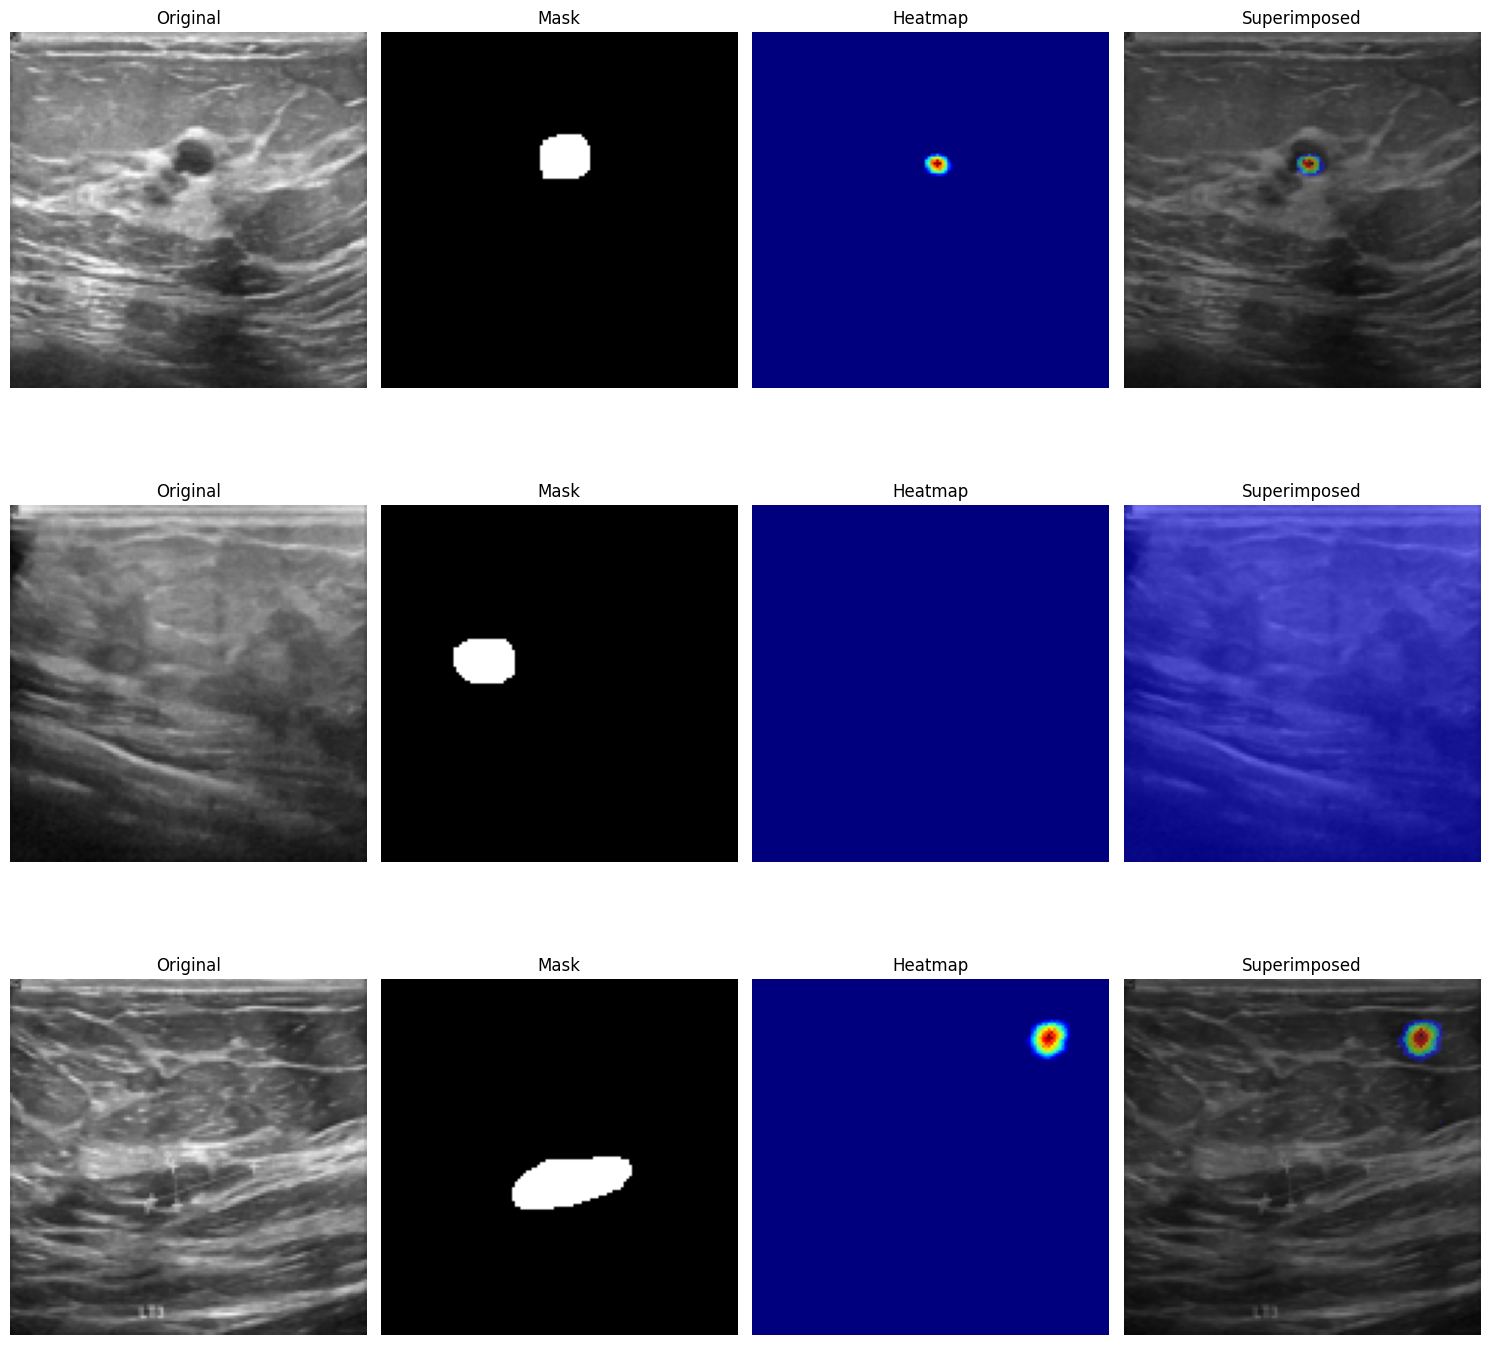

In [ ]:
# Example Usage:
# Assuming 'model' is your trained model and 'X_test' is your set of test images

last_conv_layer_name = 'conv2d_17'  # Replace with your layer's name
img_array = X_test[:3]  # Selecting the first 5 images
mask_array = Y_test[:3]

heatmaps = generate_heatmaps(img_array, model, last_conv_layer_name)
# display_images_with_heatmaps(img_array, heatmaps, save_path)
display_images_with_heatmaps(img_array,mask_array, heatmaps, save_path)

# display_images_with_heatmaps(img_array, heatmaps)
